In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the CNN model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        
        # First convolutional layer: input 1x28x28, output 32x28x28
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer: input 32x28x28, output 64x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flattened 7x7x64
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply Conv1 and Pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply Conv2 and Pooling
        x = x.view(-1, 64 * 7 * 7)  # Flatten the image for the fully connected layers
        x = torch.relu(self.fc1(x))  # Fully connected layer 1
        x = self.fc2(x)  # Output layer
        return x

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = CNN_Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')


Epoch 1, Loss: 0.1557853969870441
Accuracy on test set: 98.51%


In [9]:
import torch
import torch.nn as nn

# Define the DoubleInputLSTM model
class DoubleInputLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DoubleInputLSTM, self).__init__()
        
        # Define two separate LSTM layers for the two inputs
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Fully connected layer to combine the two LSTM outputs and produce final output
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, input1, input2):
        # Pass the first input through the first LSTM
        lstm1_out, (h1, c1) = self.lstm1(input1)
        
        # Pass the second input through the second LSTM
        lstm2_out, (h2, c2) = self.lstm2(input2)
        
        # Concatenate the LSTM outputs of both inputs (we concatenate at the feature dimension)
        combined_out = torch.cat((lstm1_out, lstm2_out), dim=-1)
        
        # Pass the combined output through a fully connected layer
        output = self.fc(combined_out)
        
        return output


# Example usage of the model
batch_size = 32
input_size = 2464
hidden_size = 200
output_size = 2464  # Same as input_size

# Create random input data for two sequences (e.g., two different feature sequences)
input1 = torch.randn(batch_size,  input_size)
input2 = torch.randn(batch_size,  input_size)

# Instantiate the model
model = DoubleInputLSTM(input_size, hidden_size, output_size)

# Forward pass through the model
output = model(input1, input2)

# Output shape should be (batch_size, seq_length, output_size)
print(f"Output shape: {output.shape}")


Output shape: torch.Size([32, 2464])


In [11]:
#https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/question_answering/Explaining%20a%20Question%20Answering%20Transformers%20Model.html
#https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

In [13]:
class_names=[str(x) for x in range(10)]

In [18]:
# define a masker that is used to mask out partitions of the input image.
import numpy as np
import shap
for i, (inputs, labels) in enumerate(trainloader, 0):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    break

def predict(img: torch.Tensor) -> torch.Tensor:
    img = torch.Tensor(img)
    output = model(img)
    return output

# Check that transformations work correctly
Xtr = inputs
out = model(Xtr[:20])
classes = torch.argmax(out, axis=1).cpu().numpy()


masker_blur = shap.maskers.Image("blur(128,128)", inputs[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=classes)
topk=1
# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[:20],
    max_evals=100,
    batch_size=40,
    outputs=shap.Explanation.argsort.flip[:topk],
)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [21]:
(shap_values.data.shape, shap_values.values.shape)

(torch.Size([20, 1, 28, 28]), (20, 1, 28, 28, 1))

In [ ]:
shap_values.values[0][

In [23]:
shap_values.values = np.array([val for val in np.moveaxis(shap_values.values, -1, 0)])

In [33]:

#shap_values.data=shap_values.data.numpy()
(shap_values.data.numpy().shape, shap_values.values[0].shape)

((20, 1, 28, 28), (20, 1, 28, 28))

In [31]:
type(shap_values.values[0])

numpy.ndarray

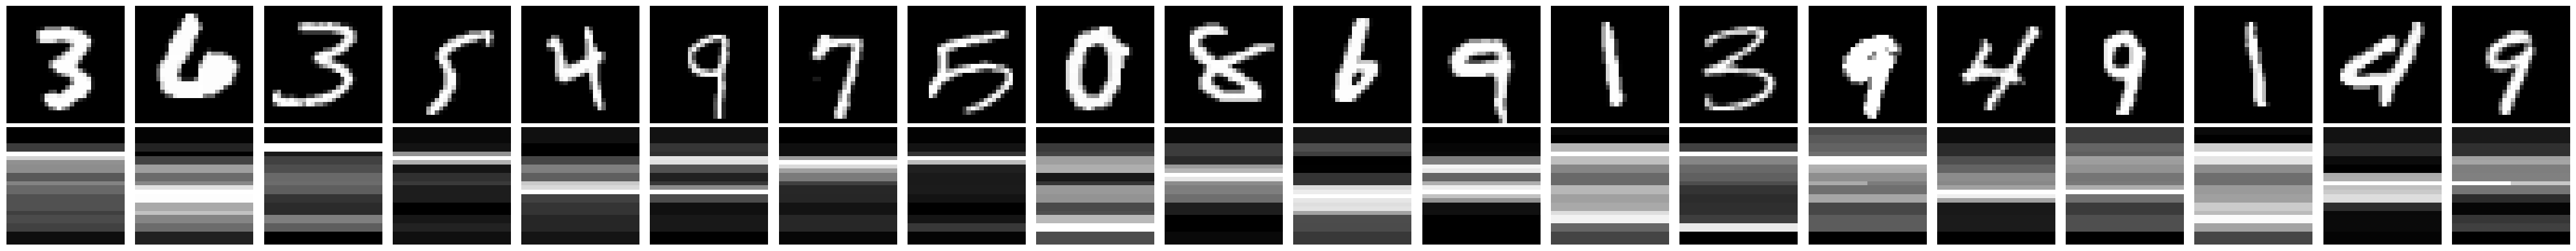

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images_side_by_side(images1, images2):
    """
    Plots two sets of grayscale images in separate rows for comparison.

    Args:
        images1 (numpy.ndarray): First set of images, shape (B, 1, H, W)
        images2 (numpy.ndarray): Second set of images, shape (B, 1, H, W)
    """
    batch_size, _, H, W = images1.shape
    fig, axes = plt.subplots(2, batch_size, figsize=(batch_size * 2, 4))

    if batch_size == 1:
        axes = np.expand_dims(axes, axis=1)  # Ensure consistent indexing for batch_size=1

    for i in range(batch_size):
        for row, images in enumerate([images1, images2]):
            img = images[i, 0]
            img = (img - img.min()) / (img.max() - img.min() + 1e-7)  # Normalize

            axes[row, i].imshow(img, cmap="gray", vmin=0, vmax=1)
            axes[row, i].axis("off")

    plt.tight_layout()
    plt.show()


plot_images_side_by_side(shap_values.data.numpy(),  shap_values.values[0])


In [11]:
import torch #plot_stacked_images()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
shap_values = shap_values.values # Remove batch & channel dim if needed
image = shap_values.data


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Original image
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

# SHAP overlay
sns.heatmap(
    shap_values, cmap=cmap, alpha=0.6, ax=ax[1], cbar=True, center=0
)
ax[1].imshow(image, cmap="gray", alpha=0.5)
ax[1].set_title(title)
ax[1].axis("off")

plt.show()

# Example usage
# mage = np.random.rand(1, 28, 28)  # Example grayscale image
# shap_values = np.random.randn(1, 28, 28)  # Example SHAP values

plot_shap_image(shap_values, image)

AttributeError: 'list' object has no attribute 'data'

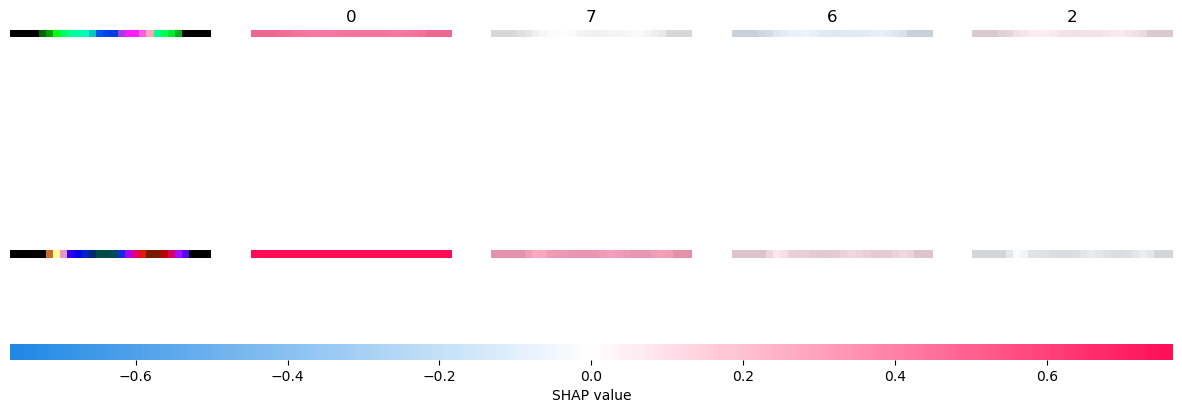

In [65]:

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
)

In [67]:
shap_values.output_names

array([['0', '7', '6', '2'],
       ['5', '9', '8', '3']], dtype='<U1')

In [103]:
np.mean(shap_values.data)

/home/user/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [21]:
shap_values[0].shape

(20, 1, 28, 28)

In [133]:
shap_values[0].shape

(20, 1, 28, 28)

In [25]:
shap_values[0].data

In [53]:
with torch.no_grad():
    for inputs1, labels in testloader:
        outputs = model(inputs1)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        break
x_test=inputs1

background = Xtr[np.random.choice(Xtr.shape[0], 5, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test)

RuntimeError: The size of tensor a (14) must match the size of tensor b (7) at non-singleton dimension 3